In [1]:
from classMVA import MVA
import numpy as np
import matplotlib.pyplot as plt


# 1. Sacamos la figura con Sklearn

## 1.1. Importamos datos para hacerlo de manera centralizada

In [2]:
import urllib2
from pyspark.mllib.regression import LabeledPoint

response = urllib2.urlopen("https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/satimage/sat.trn")
textdata = response.read()
datos = textdata.split('\n')

data = np.array(map(lambda x: np.array(map(int, x.split(' ')[:-1])), datos[:-1]))

print data.shape
print data

(4435, 36)
[[ 92 115 120 ..., 107 113  87]
 [ 84 102 106 ...,  99 104  79]
 [ 84 102 102 ...,  99 104  79]
 ..., 
 [ 68  75 108 ..., 100 104  85]
 [ 71  87 108 ...,  91 104  85]
 [ 71  91 100 ...,  91 100  81]]


## 1.2. Normalización para PCA: Simplemente eliminamos la media

In [3]:
media = np.mean(data, axis=0)
X_pca = data - media

print X_pca

[[ 22.52604284  31.14475761  20.67711387 ...,  23.84667418  13.93844419
    4.41555806]
 [ 14.52604284  18.14475761   6.67711387 ...,  15.84667418   4.93844419
   -3.58444194]
 [ 14.52604284  18.14475761   2.67711387 ...,  15.84667418   4.93844419
   -3.58444194]
 ..., 
 [ -1.47395716  -8.85524239   8.67711387 ...,  16.84667418   4.93844419
    2.41555806]
 [  1.52604284   3.14475761   8.67711387 ...,   7.84667418   4.93844419
    2.41555806]
 [  1.52604284   7.14475761   0.67711387 ...,   7.84667418   0.93844419
   -1.58444194]]


## 1.3. PCA con Numpy. Extraemos 15 componentes

In [4]:
from sklearn.decomposition import PCA

nprojections = 15
pca = PCA(n_components=nprojections)
pca.fit(X_pca)

print('La lista de varianza explicada da idea de cuánto mejora incorporar nuevas variables.')
print('Vemos que las variables 3 y sucesivas incorporan poca varianza adicional')
print(pca.explained_variance_ratio_)

X_projected = pca.transform(X_pca)


La lista de varianza explicada da idea de cuánto mejora incorporar nuevas variables.
Vemos que las variables 3 y sucesivas incorporan poca varianza adicional
[ 0.47952828  0.38123614  0.03437458  0.0241379   0.02043644  0.01673068
  0.01134075  0.00519142  0.00393668  0.00335679  0.00240124  0.00175223
  0.00165968  0.00150091  0.00122296]


## 1.4. Dibujamos los vectores de proyección

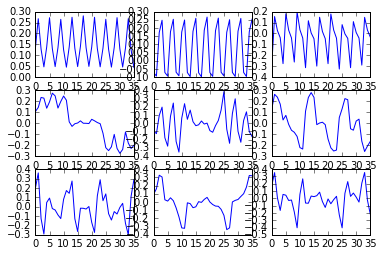

In [5]:
fig = plt.figure()

ax1 = fig.add_subplot(331)
ax1.plot(pca.components_[0,], 'b-')

ax1 = fig.add_subplot(332)
ax1.plot(pca.components_[1,], 'b-')

ax1 = fig.add_subplot(333)
ax1.plot(pca.components_[2,], 'b-')

ax1 = fig.add_subplot(334)
ax1.plot(pca.components_[3,], 'b-')

ax1 = fig.add_subplot(335)
ax1.plot(pca.components_[4,], 'b-')

ax1 = fig.add_subplot(336)
ax1.plot(pca.components_[5,], 'b-')

ax1 = fig.add_subplot(337)
ax1.plot(pca.components_[6,], 'b-')

ax1 = fig.add_subplot(338)
ax1.plot(pca.components_[7,], 'b-')

ax1 = fig.add_subplot(339)
ax1.plot(pca.components_[8,], 'b-')

plt.show()


## 1.5. Evolución de la función objetivo al incrementar el número de componentes

In [14]:
from sklearn.linear_model import LinearRegression

mses = list()

n_targets = 36

for np2 in range(nprojections):
    mse = 0
    X_components = X_projected[:,:np2+1]
    for k in range(n_targets):
        targets = X_pca[:,k]
        
        #Entrenamos modelo
        lm = LinearRegression(fit_intercept=False)
        lm.fit(X_components, targets)
        predictions = lm.predict(X_components)
        
        MSE_iter = np.mean((targets-predictions)**2)
        mse += MSE_iter
    print 'MSE para ' + str(np2+1) + ' proyecciones: ' + str(mse)
    mses.append(mse)

MSE para 1 proyecciones: 6259.91461541
MSE para 2 proyecciones: 1674.64018781
MSE para 3 proyecciones: 1261.20377487
MSE para 4 proyecciones: 970.887889414
MSE para 5 proyecciones: 725.09093335
MSE para 6 proyecciones: 523.864608692
MSE para 7 proyecciones: 387.465030233
MSE para 8 proyecciones: 325.025865327
MSE para 9 proyecciones: 277.677946935
MSE para 10 proyecciones: 237.304575556
MSE para 11 proyecciones: 208.423979837
MSE para 12 proyecciones: 187.349040521
MSE para 13 proyecciones: 167.387421129
MSE para 14 proyecciones: 149.335163713
MSE para 15 proyecciones: 134.621371702


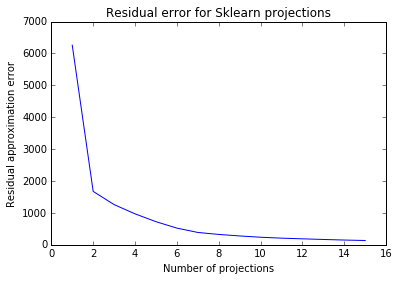

In [15]:
plt.plot(map(lambda x: x+1, range(nprojections)), mses)
plt.xlabel('Number of projections')
plt.ylabel('Residual approximation error')
plt.title('Residual error for Sklearn projections')
plt.show()

# 2. Evolución de la función objetivo para la toolbox implementada

## 2.1. Importación de datos a RDD

In [ ]:
import urllib2
from pyspark.mllib.regression import LabeledPoint

response = urllib2.urlopen("https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/satimage/sat.trn")
textdata = response.read()
RDD = sc.parallelize(textdata.split('\n')[:-1]).map(lambda line: line.split(" "))

RDD_labeled=RDD.map(lambda x: LabeledPoint(x[-1],x[0:-1]))

RDD_PCA = RDD_labeled.map(lambda x: x.features)

print RDD_PCA.take(3)

## 2.2. PCA con la toolbox. Extraemos 15 componentes

In [ ]:
#Sacamos las proyecciones con 10 features
PCA_model = MVA('PCA','l1','None',1e-5,nprojections,1e-8,1e-3,100,30)
PCA_model.fit(RDD_PCA)

(15, 36)
(36, 36)
(36, 36)
Extracting projection vector 0 out of 15
Extracting projection vector 1 out of 15
Extracting projection vector 2 out of 15
Extracting projection vector 3 out of 15
Extracting projection vector 4 out of 15
Extracting projection vector 5 out of 15
Extracting projection vector 6 out of 15
Extracting projection vector 7 out of 15
Extracting projection vector 8 out of 15


In [ ]:
from pyspark.mllib.regression import LabeledPoint, LinearRegressionWithSGD, LinearRegressionModel

RDD_projected = prueba.predict(RDD_PCA)
mses = list()

n_targets = 36

for np in range(max_feat):
    nprojections = np+1
    mse = 0
    RDD_nprojections = RDD_projected.map(lambda x: x[:nprojections])
    for k in range(n_targets):
        RDD_target = RDD_PCA.map(lambda x: x[k])
        media = RDD_target.mean()
        RDD_target = RDD_target.map(lambda x: x - media)
        
        parsedData = RDD_target.zip(RDD_nprojections)
        
        parsedData = parsedData.map(lambda x: LabeledPoint(x[0], x[1:]))
        #print parsedData.first()
        #Entrenamos el modelo
        model = LinearRegressionWithSGD.train(parsedData, iterations=100, step=1e-5)
        # Evaluate the model on training data
        valuesAndPreds = parsedData.map(lambda p: (p.label, model.predict(p.features.T)))
        MSE_iter = valuesAndPreds.map(lambda (v, p): (v - p)**2).mean()
        mse += MSE_iter
    print 'MSE para ' + str(nprojections) + ' proyecciones: ' + str(mse)
    mses.append(mse)

MSE para 1 proyecciones: [ 10131.92148449]
MSE para 2 proyecciones: [ 8191.17565693]
MSE para 3 proyecciones: [ 8163.1439772]
MSE para 4 proyecciones: [ 8163.131337]
MSE para 5 proyecciones: [ 8163.11715168]
MSE para 6 proyecciones: [ 8163.11439298]
MSE para 7 proyecciones: [ 8163.11422989]


In [6]:
num_feat=[1,2,3,4,5,6,7,8,9,10]
mses=[]
for i in range(len(num_feat)) :
    prueba = MVA('PCA','l1','None',1e-5,i+1, 0.01,1e-5,100,30)
    print num_feat[i+1]
    prueba.fit(RDD_PCA)
    U=prueba._U
    W=prueba._W
    mse=RDD_PCA.map(lambda x: np.mean(np.array(x - np.dot(W,np.dot(x, U.T)))**2)).mean()
    num_feat.append(mse)
    print mse 
    print 'First iteration for feature' + str(i+1) 

2
(1, 36)
(36, 36)
(36, 36)
Extracting projection vector 0 out of 1
(1, 36)
(36, 36)
(36, 36)
Extracting projection vector 0 out of 1
Frobenius norm error: 0.000448099874717
(1, 36)
(36, 36)
(36, 36)
Extracting projection vector 0 out of 1
Frobenius norm error: 7.66262335659e-06
1201.82218655
First iteration for feature1
3
(2, 36)
(36, 36)
(36, 36)
Extracting projection vector 0 out of 2
Extracting projection vector 1 out of 2
(2, 36)
(36, 36)
(36, 36)
Extracting projection vector 0 out of 2
Extracting projection vector 1 out of 2
Frobenius norm error: 0.0163483091633
(2, 36)
(36, 36)
(36, 36)
Extracting projection vector 0 out of 2
Extracting projection vector 1 out of 2
Frobenius norm error: 0.000107681869892
(2, 36)
(36, 36)
(36, 36)
Extracting projection vector 0 out of 2
Extracting projection vector 1 out of 2
Frobenius norm error: 1.7339870077e-06
1099.05553229
First iteration for feature2
4
(3, 36)
(36, 36)
(36, 36)
Extracting projection vector 0 out of 3
Extracting projection v

In [9]:
print num_feat

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1201.8221865491125, 1099.0555322896184, 1132.2652481206308, 1132.0606964640617, 1131.9461870983992, 1131.8777214129454, 1131.8603316602855, 1131.8569705010575, 1131.855010546891, 1131.8653408497933]


In [5]:
reg_param=[1e-8,1e-6,1e-5,1e-4, 1e-2, 1e-1,1]
Us_toolbox=[]
for i in range(len(reg_param)) :
    prueba = MVA('PCA','l1','None',1e-5,10, reg_param[i],1e-5,100,30)
    print reg_param[i]
    prueba.fit(RDD_PCA)
    Us_toolbox.append(prueba._U)
    print 'First iteration for ' + str(reg_param[i]) 


1e-08
(10, 36)
(36, 36)
(36, 36)
Extracting projection vector 0 out of 10
Extracting projection vector 1 out of 10
Extracting projection vector 2 out of 10
Extracting projection vector 3 out of 10
Extracting projection vector 4 out of 10
Extracting projection vector 5 out of 10
Extracting projection vector 6 out of 10
Extracting projection vector 7 out of 10
Extracting projection vector 8 out of 10
Extracting projection vector 9 out of 10
(10, 36)
(36, 36)
(36, 36)
Extracting projection vector 0 out of 10
Extracting projection vector 1 out of 10
Extracting projection vector 2 out of 10
Extracting projection vector 3 out of 10
Extracting projection vector 4 out of 10
Extracting projection vector 5 out of 10
Extracting projection vector 6 out of 10
Extracting projection vector 7 out of 10
Extracting projection vector 8 out of 10
Extracting projection vector 9 out of 10
Frobenius norm error: 0.0935118035042
(10, 36)
(36, 36)
(36, 36)
Extracting projection vector 0 out of 10
Extracting pro

In [4]:
reg_param=[1e-8,1e-6,1e-5,1e-4, 1e-2, 1e-1,1]
Us_toolbox=[]
for i in range(len(reg_param)) :
    prueba = MVA('OPLS','l1','norm',1e-5,10,reg_param[i],1e-3,100)
    print reg_param[i]
    prueba.fit(RDD_sat)
    Us_toolbox.append(prueba._U)
    print 'First iteration for ' + str(reg_param[i]) 

1e-08
(5, 36)
(6, 36)
(6, 6)
Extracting projection vector 0 out of 5
Extracting projection vector 1 out of 5
Extracting projection vector 2 out of 5
Extracting projection vector 3 out of 5
Extracting projection vector 4 out of 5
(5, 36)
(6, 36)
(6, 6)
Extracting projection vector 0 out of 5
Extracting projection vector 1 out of 5
Extracting projection vector 2 out of 5
Extracting projection vector 3 out of 5
Extracting projection vector 4 out of 5
Frobenius norm error: 0.00365037211321
(5, 36)
(6, 36)
(6, 6)
Extracting projection vector 0 out of 5
Extracting projection vector 1 out of 5
Extracting projection vector 2 out of 5
Extracting projection vector 3 out of 5
Extracting projection vector 4 out of 5
Frobenius norm error: 7.32919116913e-05
(5, 36)
(6, 36)
(6, 6)
Extracting projection vector 0 out of 5
Extracting projection vector 1 out of 5
Extracting projection vector 2 out of 5
Extracting projection vector 3 out of 5
Extracting projection vector 4 out of 5
Frobenius norm error: 6

LinAlgError: SVD did not converge

In [6]:
print Us_toolbox[0]

[[ -6.30723181e-02  -1.27437872e-01  -1.19432348e-01  -9.33875803e-02
   -6.44685102e-02  -1.29956344e-01  -1.22041703e-01  -9.56360878e-02
   -6.26710317e-02  -1.26094900e-01  -1.19012114e-01  -9.30626582e-02
   -6.46471576e-02  -1.30697885e-01  -1.23725996e-01  -9.73267733e-02
   -6.62108125e-02  -1.33851476e-01  -1.26914257e-01  -9.97905772e-02
   -6.42927054e-02  -1.30567696e-01  -1.23436879e-01  -9.70233629e-02
   -6.16716250e-02  -1.26716385e-01  -1.19505298e-01  -9.37392954e-02
   -6.34843619e-02  -1.29852686e-01  -1.22261474e-01  -9.59725900e-02
   -6.15594561e-02  -1.26897494e-01  -1.18763349e-01  -9.32632865e-02]
 [  7.79858877e-02   1.30514037e-01  -4.79096004e-02  -1.10976591e-01
    7.86210303e-02   1.32058038e-01  -4.95129589e-02  -1.13646178e-01
    7.66869321e-02   1.28675237e-01  -5.03380425e-02  -1.12224192e-01
    7.90079823e-02   1.34151676e-01  -5.02094938e-02  -1.16630256e-01
    8.06723832e-02   1.36773746e-01  -5.30915780e-02  -1.20157144e-01
    7.88044050e-02 

In [12]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=10)
pca.fit(RDD_PCA.collect())

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [17]:
from numpy import linalg as lin
import math
array_error=[]
for i in range(len(reg_param)-1) :
    result=math.sqrt(lin.norm(pca.components_ - Us_toolbox[i],'fro'))
    array_error.append(result)

print array_error

[1.8931920358273555, 1.893192038427425, 1.8931920358055456, 1.8931920272562606, 1.8931906089771542, 1.8931776849840662]


In [ ]:
import matplotlib.pyplot as plt
plt.plot([1e-8,1e-6,1e-5,1e-4, 1e-2, 1e-1], [Us_toolbox[0],Us_toolbox[1],Us_toolbox[0],Us_toolbox[0],Us_toolbox[0],Us_toolbox[0]], 'ro')

In [7]:
prueba = MVA('OPLS','l1','norm',1e-5,10,1e-8,1e-3,100)
prueba.fit(RDD_labeled)

(5, 36)
(6, 36)
(6, 6)
Extracting projection vector 0 out of 5
Extracting projection vector 1 out of 5
Extracting projection vector 2 out of 5
Extracting projection vector 3 out of 5
Extracting projection vector 4 out of 5
(5, 36)
(6, 36)
(6, 6)
Extracting projection vector 0 out of 5
Extracting projection vector 1 out of 5
Extracting projection vector 2 out of 5
Extracting projection vector 3 out of 5
Extracting projection vector 4 out of 5
Frobenius norm error: 0.00368934510614
(5, 36)
(6, 36)
(6, 6)
Extracting projection vector 0 out of 5
Extracting projection vector 1 out of 5
Extracting projection vector 2 out of 5
Extracting projection vector 3 out of 5
Extracting projection vector 4 out of 5
Frobenius norm error: 0.00205095620702
(5, 36)
(6, 36)
(6, 6)
Extracting projection vector 0 out of 5
Extracting projection vector 1 out of 5
Extracting projection vector 2 out of 5
Extracting projection vector 3 out of 5
Extracting projection vector 4 out of 5
Frobenius norm error: 2.221519

In [8]:
reg_param=[1e-8,1e-6,1e-5,1e-4, 1e-2, 1e-1,1]
Us_toolbox=[]
for i in range(len(reg_param)) :
    prueba = MVA('OPLS','l1','norm',1e-5,10,reg_param[i],1e-3,100)
    print reg_param[i]
    prueba.fit(RDD_labeled)
    Us_toolbox.append(prueba._U)
    print 'First iteration for ' + str(reg_param[i]) 

1e-08
(5, 36)
(6, 36)
(6, 6)
Extracting projection vector 0 out of 5
Extracting projection vector 1 out of 5
Extracting projection vector 2 out of 5
Extracting projection vector 3 out of 5
Extracting projection vector 4 out of 5
(5, 36)
(6, 36)
(6, 6)
Extracting projection vector 0 out of 5
Extracting projection vector 1 out of 5
Extracting projection vector 2 out of 5
Extracting projection vector 3 out of 5
Extracting projection vector 4 out of 5
Frobenius norm error: 0.00417402062326
(5, 36)
(6, 36)
(6, 6)
Extracting projection vector 0 out of 5
Extracting projection vector 1 out of 5
Extracting projection vector 2 out of 5
Extracting projection vector 3 out of 5
Extracting projection vector 4 out of 5
Frobenius norm error: 0.000250911143384
(5, 36)
(6, 36)
(6, 6)
Extracting projection vector 0 out of 5
Extracting projection vector 1 out of 5
Extracting projection vector 2 out of 5
Extracting projection vector 3 out of 5
Extracting projection vector 4 out of 5
Frobenius norm error: 1